# Implementar o CausalGAN no dataset MNIST

1- Usar um GAN normal para gerar dígitos (talvez alguns dígitos por vez)

2- Então usar as ideias do CausalGAN: [CausalGAN: Learning Causal Implicit Generative Models with Adversarial Training](https://arxiv.org/abs/1709.02023)

In [1]:
import struct
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import confusion_matrix, classification_report
import pandas as pd
import numpy as np
import torch
import torch.utils.data as Data
import torch.nn.functional as F
from torch import optim
from torch.autograd import Variable
from torch import nn
import matplotlib.pyplot as plt

In [2]:
file_images = '/home/ninja/MNIST/train-images.idx3-ubyte'
file_labels = '/home/ninja/MNIST/train-labels.idx1-ubyte'

In [3]:
with open(file_images,'rb') as f:
    magic, size = struct.unpack(">II", f.read(8))
    nrows, ncols = struct.unpack(">II", f.read(8))
    data1 = np.fromfile(f, dtype=np.dtype(np.uint8).newbyteorder('>'))
    data1 = data1.reshape((size, nrows, ncols))

data1.shape

(60000, 28, 28)

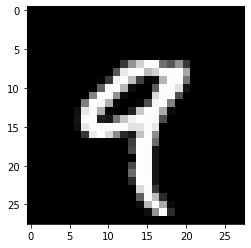

In [4]:
plt.imshow(data1[4,:,:], cmap='gray')
plt.show()

In [5]:
data = data1.reshape(data1.shape[0],data1.shape[1]*data1.shape[2])
data.shape

(60000, 784)

In [6]:
with open(file_labels,'rb') as f:
    labels = np.fromfile(f, dtype=np.dtype(np.uint8).newbyteorder('>'))

labels = labels[8:]
labels.shape

(60000,)

## WGAN - MNIST

---
* Funções de auxílio

In [7]:
def plot_losses(losses_his,title='losses'):
    plt.figure(figsize=(20,8))
    plt.subplot(221)
    plt.plot(losses_his[0])
    plt.grid(True)
    plt.xlabel('Epochs')
    plt.ylabel('Loss: Gerador')
    plt.subplot(222)
    plt.plot(losses_his[1])
    plt.grid(True)
    plt.xlabel('Epochs')
    plt.ylabel('Loss: Discriminador')
    plt.subplot(223)
    plt.plot(losses_his[2])
    plt.grid(True)
    plt.xlabel('Epochs')
    plt.ylabel('Loss: Discriminador - Real')
    plt.subplot(224)
    plt.plot(losses_his[3])
    plt.grid(True)
    plt.xlabel('Epochs')
    plt.ylabel('Loss: Discriminador - Falso')
    plt.savefig('images/'+title+'.png',quality=100)
    plt.show()

def plot_digit(x):
    x = x.data.numpy().reshape(data1.shape[1],data1.shape[2])
    plt.imshow(x,cmap='gray_r')
    plt.show()
    
def plot_n_random_digits(x,labels=None,n_images=9,title='wgan_random_digits'):
    """Ate 20 imagens"""
    indices = np.random.choice(x.shape[0],size=n_images)
    x = x[indices].data.numpy()
    if isinstance(labels, torch.IntTensor):
        sample_labels = labels[indices].data.numpy()
    else: sample_labels = ['None']*len(indices)
    x = x.reshape(n_images,data1.shape[1],data1.shape[2])
    plt.clf()
    plt.style.use('seaborn-muted')
    fig, axes = plt.subplots(2,10, figsize=(15,3), sharex=True, sharey=True,
                             subplot_kw=dict(adjustable='box', aspect='equal'))
    for i in range(n_images):
        subplot_row = i//10
        subplot_col = i%10  
        ax = axes[subplot_row, subplot_col]
        plottable_image = x[i,:]
        ax.imshow(plottable_image, cmap='gray_r')
        ax.set_title('Digit Label: {}'.format(sample_labels[i]))
        ax.set_xbound([0,28])
    plt.tight_layout()
    plt.savefig('images/'+title+'.png',quality=100)
    plt.show()

---

In [8]:
# X_data = MinMaxScaler().fit_transform(data)
X_tc = torch.Tensor(data).type(torch.FloatTensor)
y_tc = torch.Tensor(labels).type(torch.IntTensor)
print(X_tc.shape, X_tc.type(),y_tc.shape, y_tc.type())

torch.Size([60000, 784]) torch.FloatTensor torch.Size([60000]) torch.IntTensor


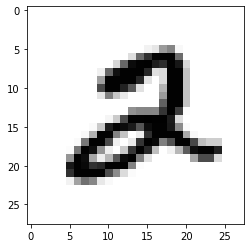

In [9]:
plot_digit(X_tc[5])

<Figure size 432x288 with 0 Axes>

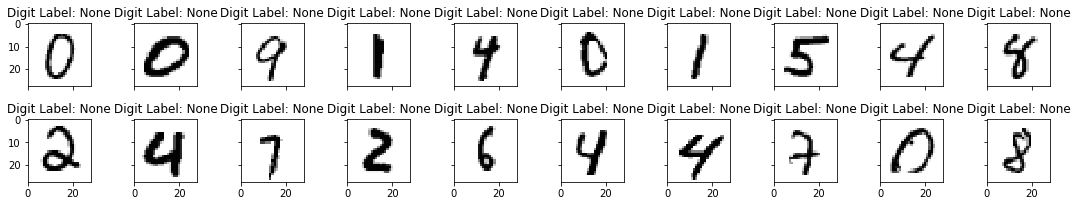

In [10]:
plot_n_random_digits(X_tc,n_images=20)

In [11]:
batch_size = 32
X_dim = X_tc.shape[1]
y_dim = y_tc.shape[0]
torch_dataset = Data.TensorDataset(X_tc,y_tc)
loader = Data.DataLoader(
        dataset = torch_dataset,
        batch_size = batch_size,
        shuffle=True,
        pin_memory=True)

In [12]:
Z_dim = 10
h_dim = 128
lr = 1e-4

# Arquitetura do Gerador
class GNet(torch.nn.Module):
    def __init__(self):
        super(GNet,self).__init__()
        self.hidden1 = torch.nn.Linear(Z_dim, h_dim)
        self.out = torch.nn.Linear(h_dim, X_dim)
    
    def forward(self,z):
        h1 = F.relu(self.hidden1(z))
        X = self.out(h1)
        return X

# Arquitetura do Discriminador
class DNet(torch.nn.Module):
    def __init__(self):
        super(DNet,self).__init__()
        self.hidden = torch.nn.Linear(X_dim, h_dim)
        self.out = torch.nn.Linear(h_dim, 1)
    
    def forward(self,X):
        h = F.relu(self.hidden(X))
        y = self.out(h)
        return y

# Instanciamos as redes
G = GNet().cuda()
D = DNet().cuda()

# Definimos os otimizadores
G_optim = optim.RMSprop(G.parameters(), lr=lr)
D_optim = optim.RMSprop(D.parameters(), lr=lr)

def init_weights(m):
    if type(m) == nn.Linear:
        torch.nn.init.xavier_normal_(m.weight).cuda()
        m.bias.data.fill_(0.0001)  

def discriminator_test(n_sample,G,D):
    z = Variable(torch.randn(n_sample, Z_dim)).cuda()
    G_sample = G(z)
    prob_real = D(X_tc.cuda())
    prob_fake = D(G_sample)
    print('Average real {:.6f}| Std real {:.6f}'.format(prob_real.mean(),prob_real.std()))
    print('Average fake {:.6f}| Std fake {:.6f}'.format(prob_fake.mean(),prob_fake.std()))

In [26]:
#load saved networks
# G.load_state_dict(torch.load('models/g_wgan_mnist_200k.pt'))
# D.load_state_dict(torch.load('models/d_wgan_mnist_200k.pt'))

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

In [39]:
%%time
epochs = 500000
epochs_discriminator = 5
G_his, D_his,D_real_his,D_fake_his = [[],[],[],[]]
losses_his = [G_his,D_his,D_real_his,D_fake_his] 

for epoch in range(epochs):
    for i in range(epochs_discriminator):
        batch_x = next(iter(loader))
        # Discriminador
        X = Variable(batch_x[0]).cuda()
        G_sample = G(Variable(torch.randn(batch_size, Z_dim)).cuda())
        D_real = D(X)
        D_fake = D(G_sample)
        D_loss_real = torch.mean(D_real)
        D_loss_fake = torch.mean(D_fake)
        D_loss = -(D_loss_real - D_loss_fake)
        D_loss.backward()
        D_optim.step()
        for p in D.parameters():
            p.data.clamp_(-0.01, 0.01)
        D_optim.zero_grad()
        G_optim.zero_grad()

    # Generator
    G_sample = G(Variable(torch.randn(batch_size, Z_dim)).cuda())
    D_fake = D(G_sample)
    G_loss = -torch.mean(D_fake)
    G_loss.backward()
    G_optim.step()
    G_optim.zero_grad()

    G_his.append(G_loss.mean().data)    # Recolher dados das funções de perda
    D_his.append(D_loss.mean().data)
    D_fake_his.append(D_loss_fake.mean().data)
    D_real_his.append(D_loss_real.mean().data)

    if epoch % int(epochs/20) == 0:      # Mostrar dados ao longo das epochs
        print('Epoch-{}| Average D_loss: {:.6f}| Average G_loss: {:.6f}'.format(
            epoch, D_loss.data, G_loss.data))

Epoch-0| Average D_loss: -2.763005| Average G_loss: -0.490288
Epoch-25000| Average D_loss: -2.457820| Average G_loss: -0.500639
Epoch-50000| Average D_loss: -2.927495| Average G_loss: -0.976231
Epoch-75000| Average D_loss: -2.833433| Average G_loss: -0.544753
Epoch-100000| Average D_loss: -2.353064| Average G_loss: -0.663670
Epoch-125000| Average D_loss: -3.063176| Average G_loss: -0.286293
Epoch-150000| Average D_loss: -2.783551| Average G_loss: -0.597434
Epoch-175000| Average D_loss: -2.684318| Average G_loss: -0.569503
Epoch-200000| Average D_loss: -2.787630| Average G_loss: -0.730871
Epoch-225000| Average D_loss: -2.952497| Average G_loss: 0.015454
Epoch-250000| Average D_loss: -2.886234| Average G_loss: -0.260926
Epoch-275000| Average D_loss: -2.723417| Average G_loss: -0.134180
Epoch-300000| Average D_loss: -2.568464| Average G_loss: -0.198555
Epoch-325000| Average D_loss: -2.538894| Average G_loss: -0.237279
Epoch-350000| Average D_loss: -2.531431| Average G_loss: -0.118594
Epoc

<Figure size 432x288 with 0 Axes>

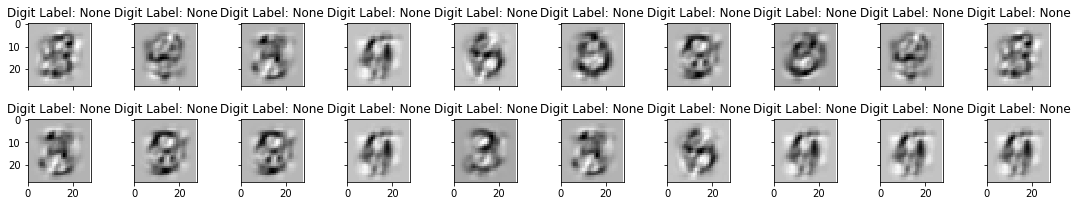

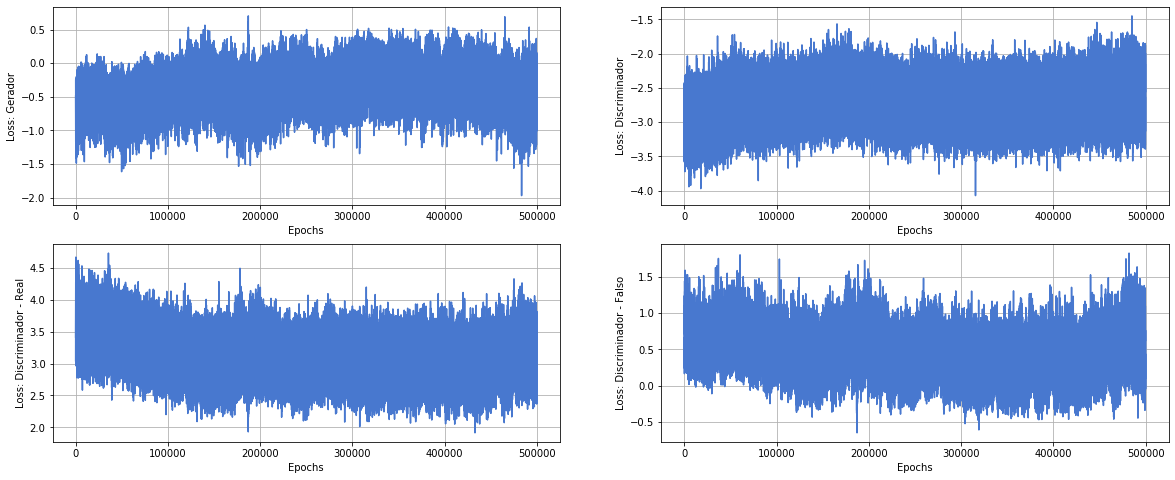

Average real 3.010915| Std real 1.220142
Average fake 0.323102| Std fake 0.947816


In [40]:
# 1M epochs
plot_n_random_digits(G(Variable(torch.randn(20, Z_dim)).cuda()).cpu(),n_images=20,title='wgan_generated_digits_1m')
plot_losses(losses_his,title='wgan_losses_1m')
discriminator_test(1000,G,D)

<Figure size 432x288 with 0 Axes>

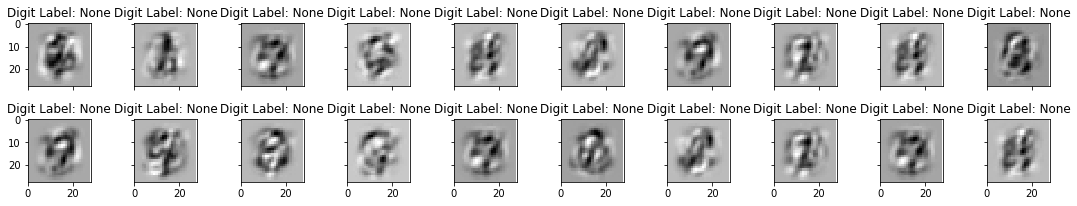

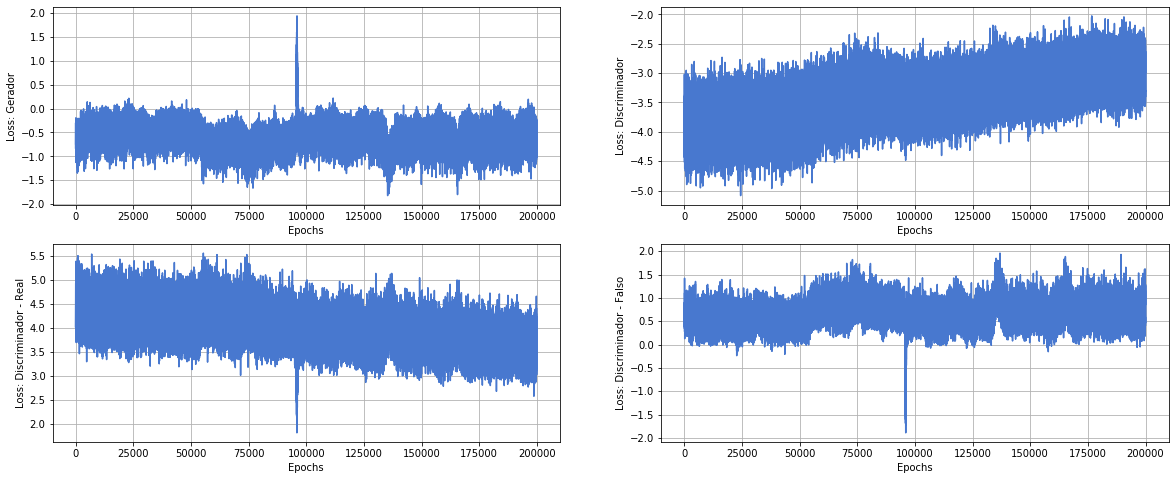

Average real 3.639340| Std real 1.166683
Average fake 0.663660| Std fake 0.541041


In [38]:
# 500000 epochs
plot_n_random_digits(G(Variable(torch.randn(20, Z_dim)).cuda()).cpu(),n_images=20,title='wgan_generated_digits_500k')
plot_losses(losses_his,title='wgan_losses_500k')
discriminator_test(1000,G,D)

<Figure size 432x288 with 0 Axes>

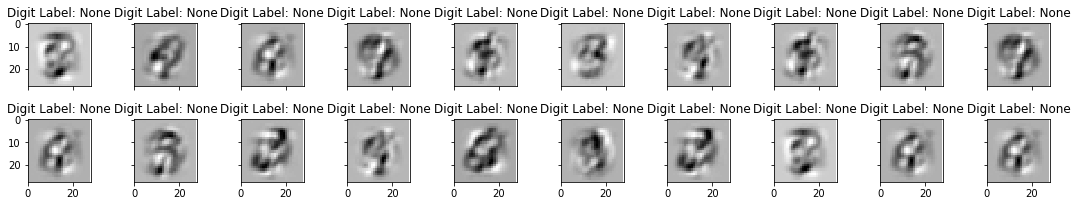

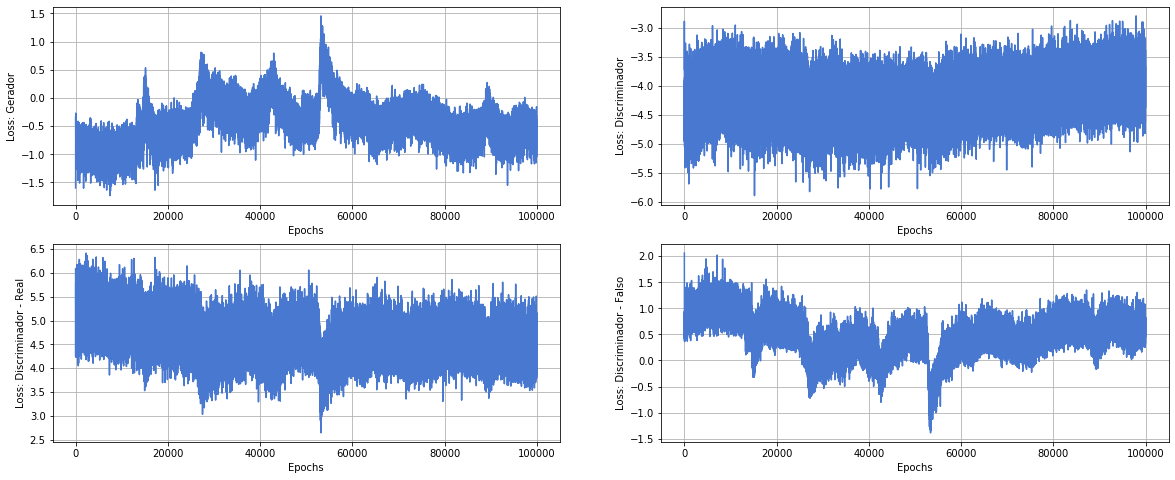

Average real 4.395007| Std real 1.521450
Average fake 0.577142| Std fake 0.454761


In [30]:
# 310000 epochs
plot_n_random_digits(G(Variable(torch.randn(20, Z_dim)).cuda()).cpu(),n_images=20,title='wgan_generated_digits_300k')
plot_losses(losses_his,title='wgan_losses_300k')
discriminator_test(1000,G,D)

<Figure size 432x288 with 0 Axes>

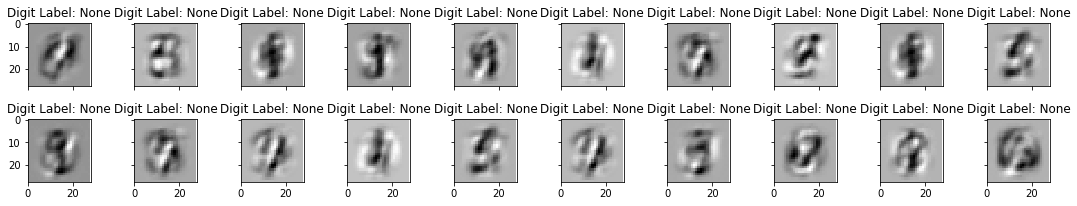

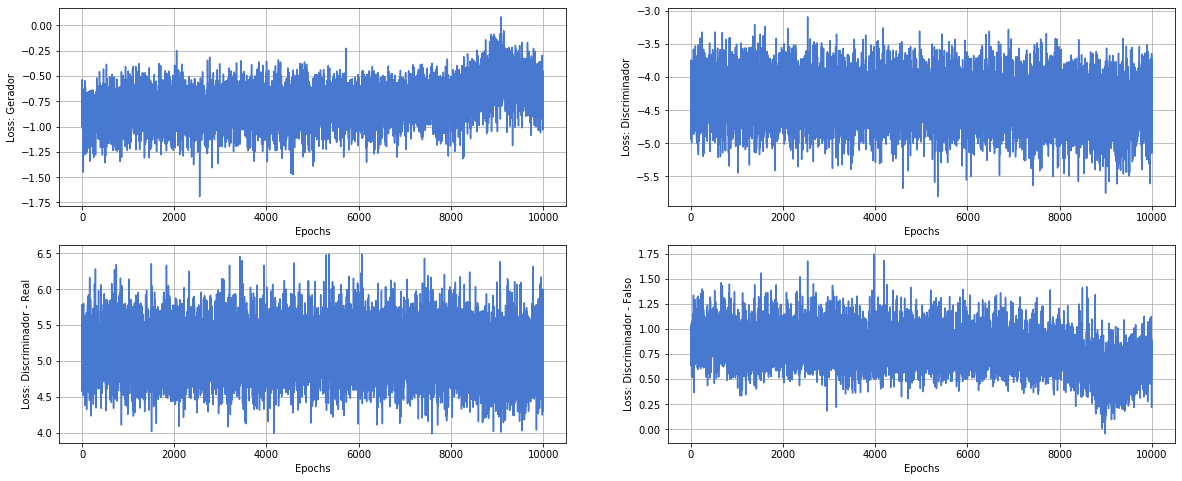

Average real 5.114705| Std real 1.865416
Average fake 0.697337| Std fake 0.481705


In [50]:
# 210000 epochs
G_sample_plot = G(Variable(torch.randn(20, Z_dim)).cuda())
plot_n_random_digits(G_sample_plot.cpu(),n_images=20)
plot_losses(losses_his)
discriminator_test(1000,G,D)

<Figure size 432x288 with 0 Axes>

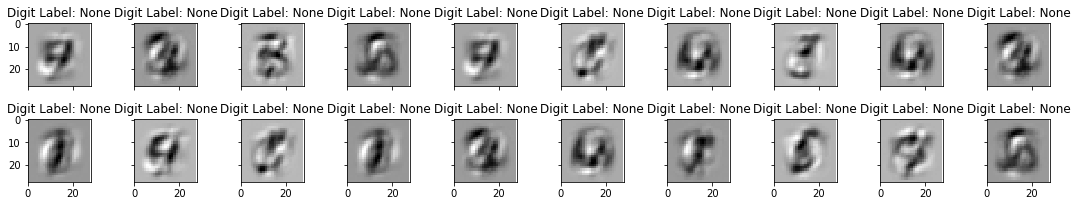

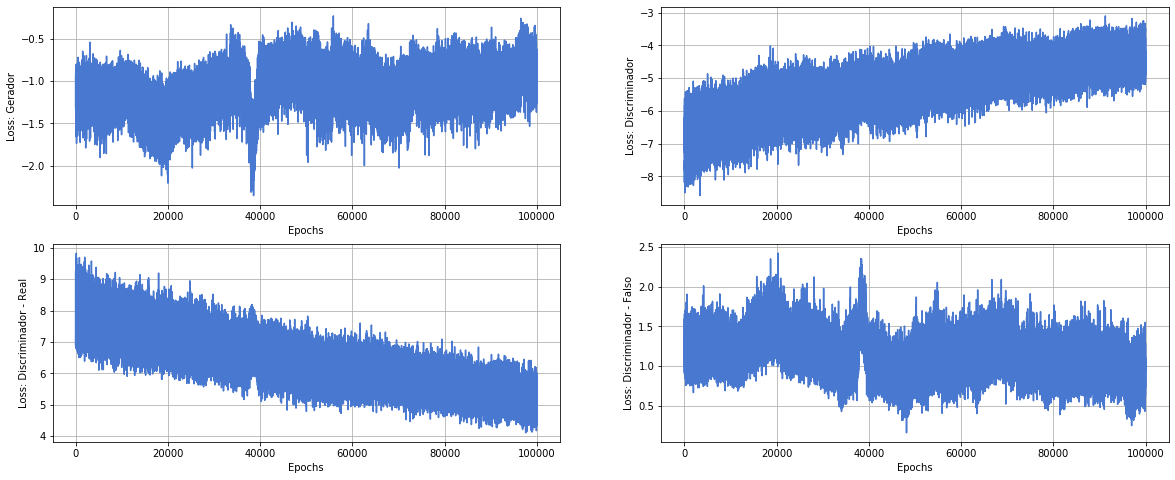

Average real 4.974466| Std real 1.817096
Average fake 0.688557| Std fake 0.526735


In [34]:
# 200000 epochs
G_sample_plot = G(Variable(torch.randn(20, Z_dim)).cuda())
plot_n_random_digits(G_sample_plot.cpu(),n_images=20)
plot_losses(losses_his)
discriminator_test(1000,G,D)

<Figure size 432x288 with 0 Axes>

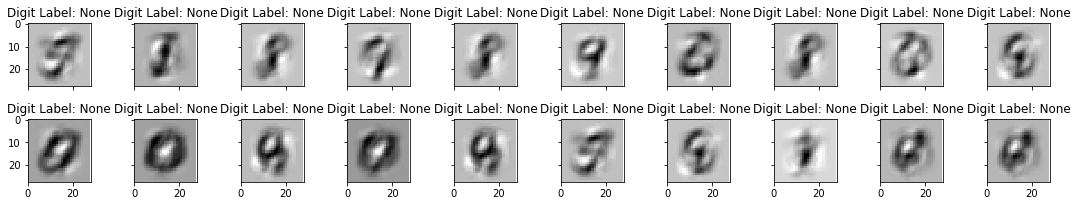

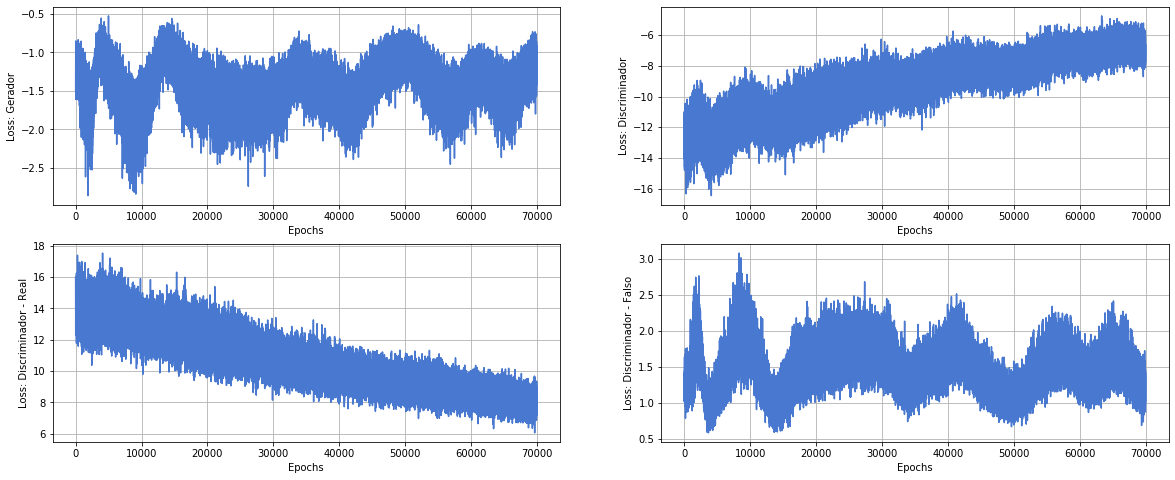

Average real 7.935840| Std real 2.986704
Average fake 1.140178| Std fake 0.555255


In [23]:
# 100000 epochs
G_sample_plot = G(Variable(torch.randn(20, Z_dim)).cuda())
plot_n_random_digits(G_sample_plot.cpu(),n_images=20)
plot_losses(losses_his)
discriminator_test(1000,G,D)

<Figure size 432x288 with 0 Axes>

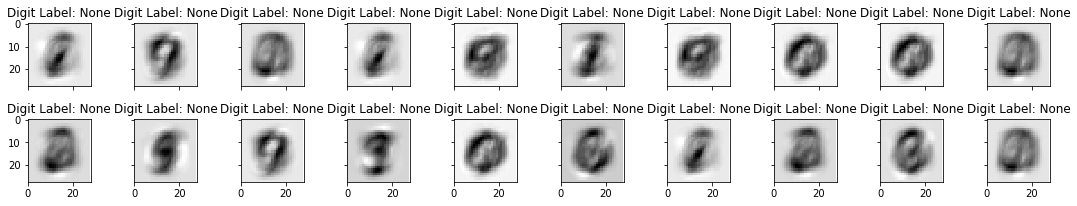

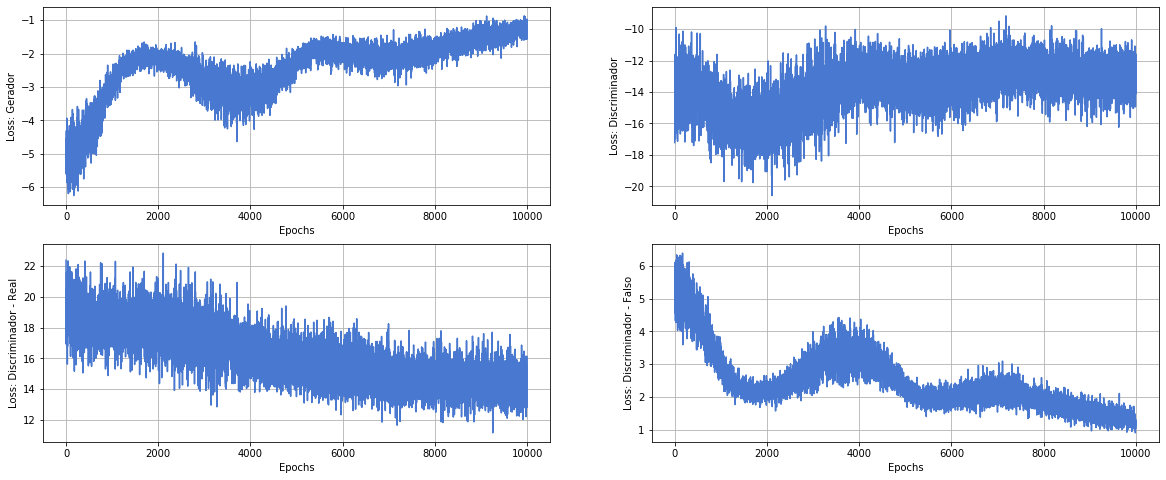

Average real 14.359377| Std real 5.387416
Average fake 1.355618| Std fake 0.694293


In [21]:
# 30000 epochs
G_sample_plot = G(Variable(torch.randn(20, Z_dim)).cuda())
plot_n_random_digits(G_sample_plot.cpu(),n_images=20)
plot_losses(losses_his)
discriminator_test(1000,G,D)

<Figure size 432x288 with 0 Axes>

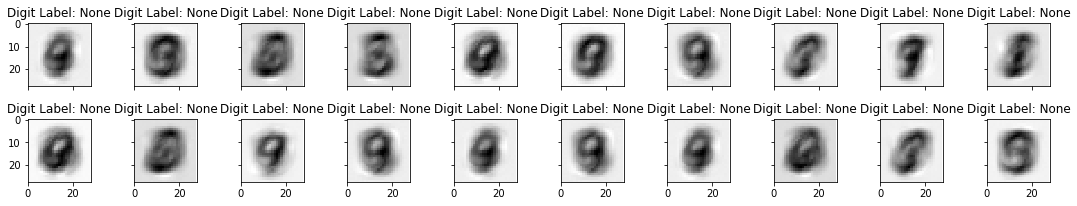

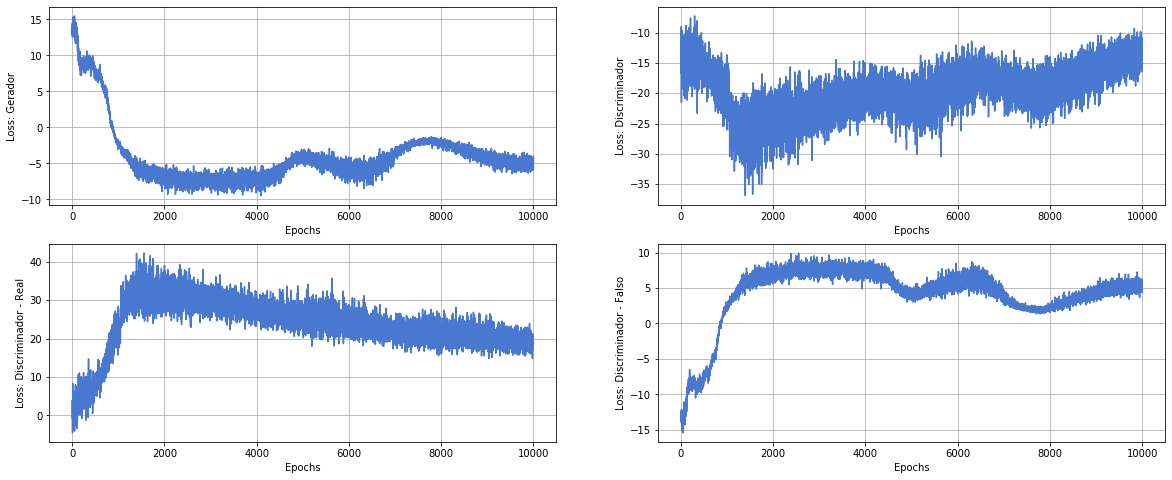

Average real 18.982109| Std real 8.341753
Average fake 5.124129| Std fake 2.978527


In [19]:
# 20000 epochs
G_sample_plot = G(Variable(torch.randn(20, Z_dim)).cuda())
plot_n_random_digits(G_sample_plot.cpu(),n_images=20)
plot_losses(losses_his)
discriminator_test(1000,G,D)

<Figure size 432x288 with 0 Axes>

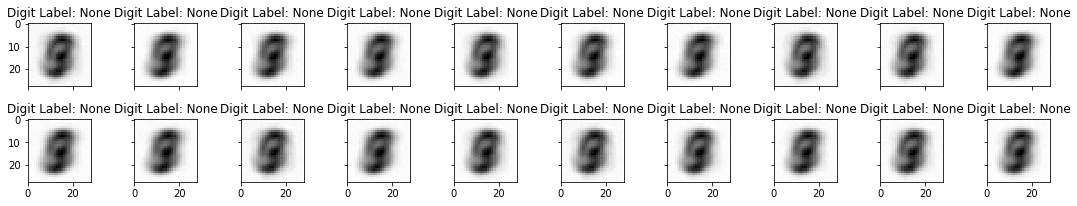

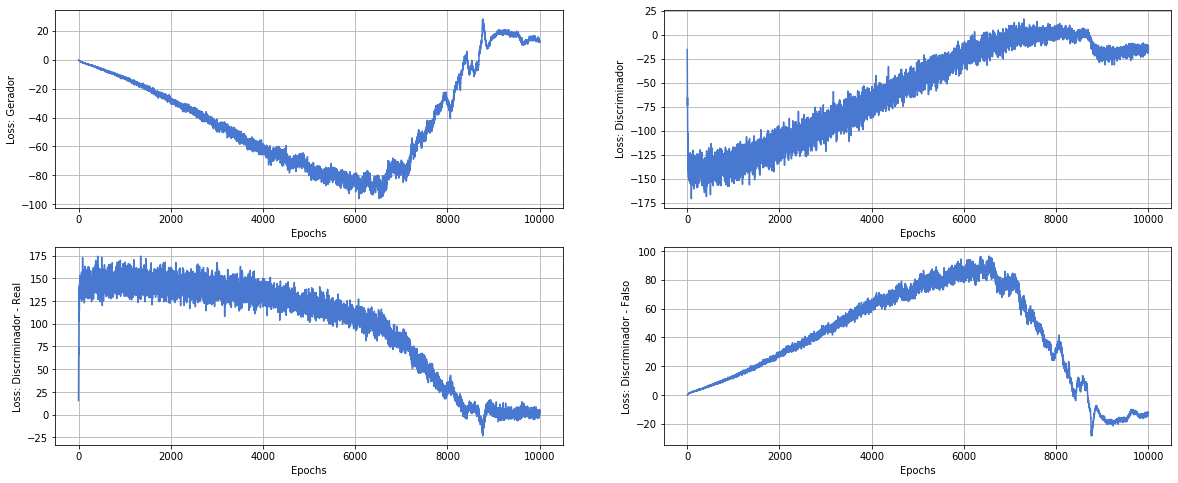

Average real 1.789914| Std real 15.182210
Average fake -12.940498| Std fake 2.486334


In [17]:
# 10000 epochs
G_sample_plot = G(Variable(torch.randn(20, Z_dim)).cuda())
plot_n_random_digits(G_sample_plot.cpu(),n_images=20)
plot_losses(losses_his)
discriminator_test(1000,G,D)

In [41]:
#save networks
torch.save(G.state_dict(), 'models/g_wgan_mnist_1m.pt')
torch.save(D.state_dict(), 'models/d_wgan_mnist_1m.pt')

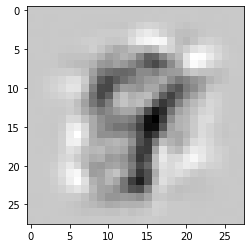

In [49]:
plot_digit(G(Variable(torch.randn(1, Z_dim)).cuda()).cpu())